In [17]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow import keras

In [284]:
BATCH_SIZE = 32
OUT = 3
INPUT_SHAPE = (32,32,3)
EPOCHS = 10
INPUT_IMAGE_SIZE = (INPUT_SHAPE[0], INPUT_SHAPE[1])
FILTERS = 3

In [285]:
from tensorflow.keras.datasets import mnist, fashion_mnist

def load_data(choice='mnist', labels=False):
    if choice not in ['mnist', 'fashion_mnist']:
        raise ('Choices are mnist and fashion_mnist')
    
    if choice is 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    X_train, X_test = X_train / 255., X_test / 255.
    X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])
    X_train = X_train.astype(np.float32, copy=False)
    X_test = X_test.astype(np.float32, copy=False)
    
    if labels:
        return (X_train, y_train), (X_test, y_test)
    
    return X_train, X_test


def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (28, 28)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (28, 28)), aspect='auto')
    plt.tight_layout()

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-285-1112dd454573>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if choice is 'mnist':


In [286]:
def plot_digits(X, y, encoder, batch_size=128):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.show()
    
    
def generate_manifold(decoder):
    # display a 30x30 2D manifold of digits
    n = 2
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit        
    
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [287]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

# Mask detection

In [288]:
datagen = ImageDataGenerator(
    rescale = 1.0 / 255, 
    horizontal_flip=True, 
    zoom_range=0.1, 
    shear_range=0.2, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    rotation_range=4, 
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    rescale = 1.0 / 255
)

In [289]:
train_dataset = datagen.flow_from_directory(
    directory="./mask_dataset/train",
    target_size=INPUT_IMAGE_SIZE,
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

validation_dataset = val_datagen.flow_from_directory(
    directory = "./mask_dataset/val",
    target_size = INPUT_IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_dataset = val_datagen.flow_from_directory(
    directory = "./mask_dataset/test",
    target_size = INPUT_IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 3876 images belonging to 3 classes.
Found 1036 images belonging to 3 classes.
Found 465 images belonging to 3 classes.


This practise work is about unsupervised learning, so that we must delete labels to the photos

In [290]:
train_data = np.concatenate([train_dataset.next()[0] for i in range(len(train_dataset))])
validation_data = np.concatenate([validation_dataset.next()[0] for i in range(len(validation_dataset))])
test_data = np.concatenate([test_dataset.next()[0] for i in range(len(test_dataset))])

train_labels = np.concatenate([train_dataset.next()[1] for i in range(len(train_dataset))])
validation_labels = np.concatenate([validation_dataset.next()[0] for i in range(len(validation_dataset))])
test_labels = np.concatenate([test_dataset.next()[1] for i in range(len(test_dataset))])

print(f"shapes: train = {train_data.shape}, validation = {validation_data.shape}, test = {test_data.shape}")

shapes: train = (3876, 32, 32, 3), validation = (1036, 32, 32, 3), test = (465, 32, 32, 3)


# MNIST

In [293]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0.0, stddev=1.0, name="epsilon")
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [294]:
HIDDEN_DIM = 512
LATENT_DIM = 2
num_features = 784
EPOCHS=50

#### Encoder

In [295]:
inputs = tf.keras.layers.Input(shape=(num_features, ), name = "input")
x = tf.keras.layers.Dense(HIDDEN_DIM, activation="relu")(inputs)
z_mean = tf.keras.layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 dense_74 (Dense)               (None, 512)          401920      ['input[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_74[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_74[0][0]']               
                                                                                            

#### Decoder

In [296]:
latent_inputs = tf.keras.layers.Input(shape=(LATENT_DIM, ), name="z_sampling")
x = tf.keras.layers.Dense(HIDDEN_DIM, activation="relu")(latent_inputs)
outputs = tf.keras.layers.Dense(num_features, activation="sigmoid")(x)

decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_75 (Dense)            (None, 512)               1536      
                                                                 
 dense_76 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [304]:
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name="vae")

In [298]:
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)

vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          403972      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          403728      ['encoder[0][2]']                
                                                                                                

In [299]:
(X_train, _),  (X_test, y) = load_data('mnist', labels=True)
vae.fit(X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, None))

Epoch 1/50
1875/1875 [==============================] - 9s 4ms/step - loss: 45.6809 - val_loss: 42.2351
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 41.8534 - val_loss: 41.1708
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 41.0546 - val_loss: 40.5331
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 40.5423 - val_loss: 40.3410
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 40.1150 - val_loss: 39.9417
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 39.7409 - val_loss: 39.5350
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 39.4618 - val_loss: 39.2784
Epoch 8/50
1875/1875 [==============================] - 7s 4ms/step - loss: 39.1895 - val_loss: 39.1580
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 38.9691 - val_loss: 39.0143
Epoch 10/50
1875/1875 [==============================] - 7s 4ms/

In [300]:
result = vae.predict(X_test)

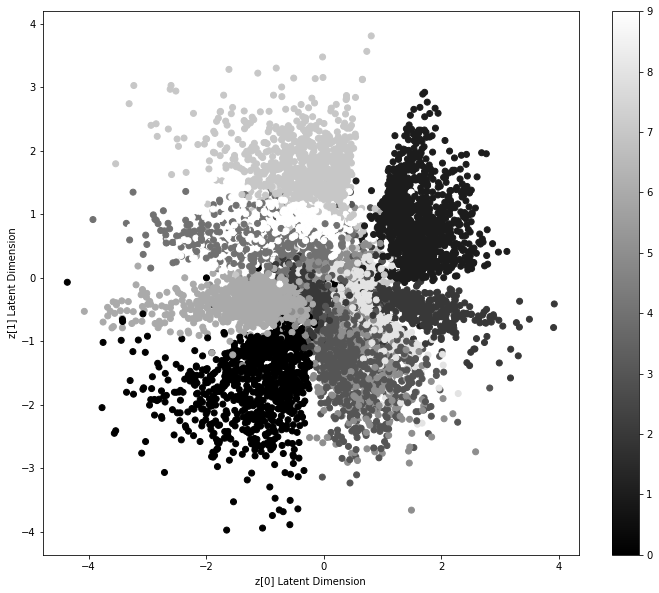

In [301]:
plot_digits(X_test, y, encoder)  # y for label coloring

In [302]:
result = np.reshape(result, (result.shape[0], 28, 28))

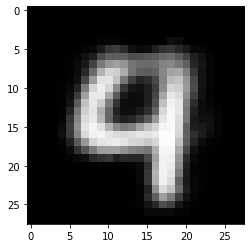

In [303]:
plt.imshow(result[4], cmap='Greys_r')
plt.show()

# Face mask images

#### Encoder

In [229]:
FILTERS_NUM = 64
LATENT_DIM = 128

In [195]:
inputs = tf.keras.layers.Input(shape=(num_features, ), name = "input")
x = tf.keras.layers.Dense(HIDDEN_DIM, activation="relu")(inputs)
z_mean = tf.keras.layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 12288)]      0           []                               
                                                                                                  
 dense_50 (Dense)               (None, 512)          6291968     ['input[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 128)          65664       ['dense_50[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 128)          65664       ['dense_50[0][0]']               
                                                                                            

#### Decoder

In [196]:
latent_inputs = tf.keras.layers.Input(shape=(LATENT_DIM, ), name="z_sampling")
x = tf.keras.layers.Dense(HIDDEN_DIM, activation="relu")(latent_inputs)
outputs = tf.keras.layers.Dense(num_features, activation="sigmoid")(x)

decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 128)]             0         
                                                                 
 dense_51 (Dense)            (None, 512)               66048     
                                                                 
 dense_52 (Dense)            (None, 12288)             6303744   
                                                                 
Total params: 6,369,792
Trainable params: 6,369,792
Non-trainable params: 0
_________________________________________________________________


In [197]:
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name="vae")

In [198]:
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)

vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 12288)]      0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        6423296     ['input[0][0]']                  
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 decoder (Functional)           (None, 12288)        6369792     ['encoder[0][2]']                
                                                                                                

In [217]:
def encoder_conv2d(latent_dim):
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input")
    
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = keras.layers.BatchNormalization()(conv4)
    
    x = tf.keras.layers.Flatten()(conv4)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    
    z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    
    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [232]:
def encoder_2d_cut(latent_dim):
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name='input')

    x = tf.keras.layers.Conv2D(FILTERS_NUM, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = tf.keras.layers.Conv2D(FILTERS_NUM*2, (3, 3), activation='relu', strides=2, padding='same')(x)

    # shape info needed to build decoder model
    shape = x.get_shape().as_list()

    # generate latent vector Q(z|X)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    z_mean = tf.keras.layers.Dense(LATENT_DIM, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(LATENT_DIM, name='z_log_var')(x)

    z = tf.keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

In [233]:
_encoder = encoder_2d_cut(LATENT_DIM)
_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 64)   1792        ['input[0][0]']                  
                                                                                                  
 conv2d_43 (Conv2D)             (None, 16, 16, 128)  73856       ['conv2d_42[0][0]']              
                                                                                                  
 flatten_5 (Flatten)            (None, 32768)        0           ['conv2d_43[0][0]']              
                                                                                            

#### Decoder

In [322]:
def decoder_conv2d():
    
    latent_inputs = tf.keras.Input(shape=INPUT_SHAPE, name="z_sampling")
    
    conv5 = keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(latent_inputs)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(latent_inputs)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv6 = keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(latent_inputs)
    conv6 = keras.layers.BatchNormalization()(conv6)
    conv6 = keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = keras.layers.BatchNormalization()(conv6)
    ups_1 = keras.layers.UpSampling2D((2,2))(conv6)
    conv7 = keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(ups_1)
    conv7 = keras.layers.BatchNormalization()(conv7)
    conv7 = keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = keras.layers.BatchNormalization()(conv7)
    ups_2 = keras.layers.UpSampling2D((2,2))(conv7)
    decoded = keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name="decoded_out")(ups_2)
    
    decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")
    
    return decoder

In [323]:
def decoder_2d_cut():
    latent_inputs = tf.keras.Input(shape=(LATENT_DIM,), name='z_sampling')
    x = tf.keras.layers.Dense(INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2], activation='relu')(latent_inputs)
    x = tf.keras.layers.Reshape((INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))(x)
    x = tf.keras.layers.Conv2DTranspose(FILTERS*2, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(FILTERS, (3, 3), activation='relu', strides=2, padding='same')(x)
    outputs = tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

    # instantiate decoder model
    decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
    return decoder

In [324]:
_decoder = decoder_conv2d()
_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_transpose_49 (Conv2D  (None, 32, 32, 64)       1792      
 Transpose)                                                      
                                                                 
 batch_normalization_48 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 32, 32, 64)       36928     
 Transpose)                                                      
                                                                 
 batch_normalization_49 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

In [325]:
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input")
outputs = _decoder(_encoder(INPUT_SHAPE)[2])
vae = kr.Model(inputs, outputs, name="vae")

ValueError: Layer "encoder" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=32>, <tf.Tensor: shape=(), dtype=int32, numpy=32>, <tf.Tensor: shape=(), dtype=int32, numpy=3>]

In [326]:
inputs = tf.keras.Input(shape=INPUT_SHAPE, name='input')

x = tf.keras.layers.Conv2D(FILTERS, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = tf.keras.layers.Conv2D(FILTERS*2, (3, 3), activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = x.get_shape().as_list()

# generate latent vector Q(z|X)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
z_mean = tf.keras.layers.Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(LATENT_DIM, name='z_log_var')(x)

z = tf.keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_56 (Conv2D)             (None, 16, 16, 3)    84          ['input[0][0]']                  
                                                                                                  
 conv2d_57 (Conv2D)             (None, 8, 8, 6)      168         ['conv2d_56[0][0]']              
                                                                                                  
 flatten_12 (Flatten)           (None, 384)          0           ['conv2d_57[0][0]']              
                                                                                            

In [331]:
# build decoder model
latent_inputs = tf.keras.Input(shape=(LATENT_DIM,), name='z_sampling')
x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)
x = tf.keras.layers.Conv2DTranspose(FILTERS*2, (3, 3), activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(FILTERS, (3, 3), activation='relu', strides=2, padding='same')(x)
outputs = tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_82 (Dense)            (None, 384)               1152      
                                                                 
 reshape_16 (Reshape)        (None, 8, 8, 6)           0         
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 16, 16, 6)        330       
 Transpose)                                                      
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 32, 32, 3)        165       
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTrans  (None, 32, 32, 3)        84  

In [332]:
outputs.get_shape()

TensorShape([None, 32, 32, 3])

In [333]:
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')

In [334]:
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          6480        ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 32, 32, 3)    1731        ['encoder[1][2]']                
                                                                                                

In [314]:
train_data[0].shape

(32, 32, 3)

In [315]:
vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(validation_data, None))

Epoch 1/50
115/122 [===========================>..] - ETA: 0s - loss: 36.0662

InvalidArgumentError:  Incompatible shapes: [4,32,32] vs. [4]
	 [[node gradient_tape/vae/tf.__operators__.add_45/BroadcastGradientArgs
 (defined at /opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:464)
]] [Op:__inference_train_function_1297801]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/vae/tf.__operators__.add_45/BroadcastGradientArgs:
In[0] gradient_tape/vae/tf.__operators__.add_45/Shape:	
In[1] gradient_tape/vae/tf.__operators__.add_45/Shape_1:

Operation defined at: (most recent call last)
>>>   File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/opt/conda/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-312-51b79425a8ad>", line 2, in <module>
>>>     vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(validation_data, None))
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 